In [6]:
!pip install cdlib

In [7]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pickle

from itertools import combinations, groupby

# https://github.com/GiulioRossetti/cdlib
from cdlib import algorithms, viz

# reference
# https://stackoverflow.com/questions/16566871/node-size-dependent-on-the-node-degree-on-networkx
# https://stackoverflow.com/questions/6461713/using-draw-networkx-how-to-show-multiple-drawing-windows

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'leidenalg', 'karateclub', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


In [ ]:
def classification(graph):
    pos = nx.spring_layout(graph)
    coms_wt = algorithms.walktrap(graph)
    coms_ld = algorithms.leiden(graph)  
    coms_lv = algorithms.louvain(graph)
    coms_sc = algorithms.surprise_communities(graph)
    
    # plt.subplot(221)
    print('Walktrap')
    viz.plot_network_clusters(graph, coms_wt, pos, figsize=(5, 5), plot_labels=False)
    
    # plt.subplot(222)
    print('Leiden')
    viz.plot_network_clusters(graph, coms_ld, pos, figsize=(5, 5), plot_labels=False)
    
    print('Louvain')
    viz.plot_network_clusters(graph, coms_lv, pos, figsize=(5, 5), plot_labels=False)
    
    print('Surprise Communities')
    viz.plot_network_clusters(graph, coms_sc, pos, figsize=(5, 5), plot_labels=False)
    
    plt.show() 

In [ ]:
# source
# https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx

def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    if p <= 0:
        return G
    
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [ ]:
graph_list = []
density = 0.0004

for x in range(0, 50):
    random_size = random.randint(40, 300)

    G = gnp_random_connected_graph(random_size, density)
    
    # trim excess, unconnected nodes
    G.remove_nodes_from(list(nx.isolates(G)))
    
    if x % 10 == 0:
        density = density * 3
        
    
    graph_list.append(G)

In [ ]:
filename = './graph_list.pkl'
with open(filename, 'wb') as f:
    pickle.dump(graph_list, f)

### Use Cache of Graphs

In [ ]:
with open(filename, 'rb') as f:
    list_of_dicts = pickle.load(f)

Figure 0
Walktrap
Leiden
Louvain
Surprise Communities


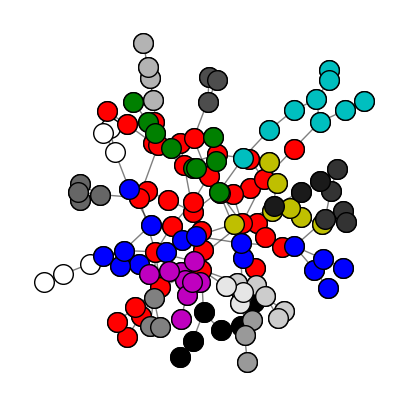

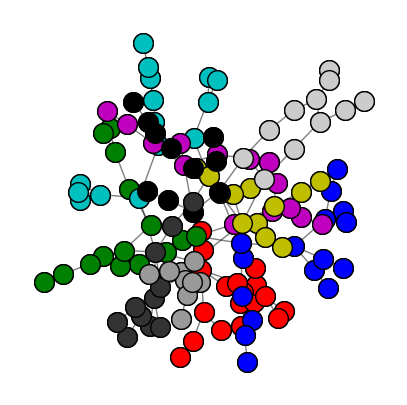

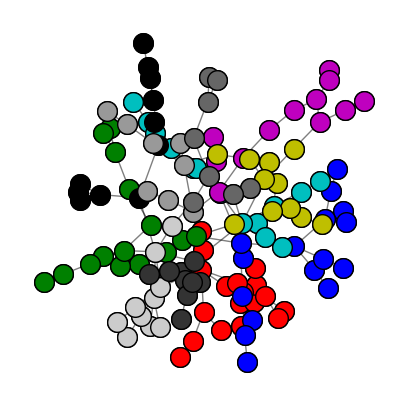

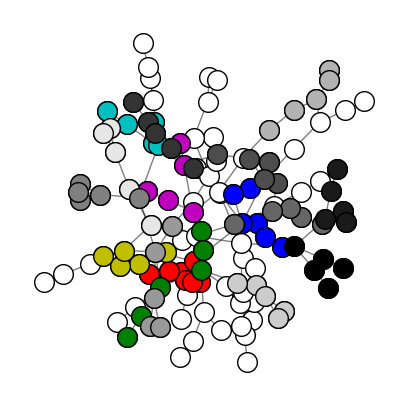

In [ ]:
sublist = [list_of_dicts[i] for i in [2, 5, 6, 22, 28, 41]]

for x, G in enumerate(sublist):
    print(f'Figure {x}')
    # plt.figure(x)
    
    # nx.draw(G, node_size=50)
    classification(G) 
    break

In [ ]:
def node_elimination(input_graph, verbose=True):

    degraded_graph = input_graph.copy()

    nodes_to_remove = list(degraded_graph.nodes)
    num_nodes = len(list(degraded_graph.nodes))
    max_removed_nodes = 0
    node_elimination_events = 0
    network_destroyed = False
    removed_nodes = []
    max_nodes_removed_percentage = 0.3

    max_nodes_to_remove = int(num_nodes * max_nodes_removed_percentage)

    for x in range(0, max_nodes_to_remove):
        node_elimination_events += 1
        target_node = random.choice(nodes_to_remove)
        nodes_to_remove.remove(target_node)
        removed_nodes.append(target_node)  # keep track of nodes removed 

        degraded_graph.remove_node(target_node)
        max_removed_nodes = max_removed_nodes + 1

        subgraph_list = sorted(nx.connected_components(degraded_graph), key=len, reverse=True)
        
        # get a network object from the subnet.  Pull it out of the graph
        largest_subnet = degraded_graph.subgraph(subgraph_list[0])

        # if existing network is at least 70% in size of original, keep going!
        if largest_subnet.number_of_nodes() >= input_graph.number_of_nodes()* 0.7:
            last_connected_node = degraded_graph

        else:
            subgraph_list = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            network_destroyed = True
            break
            
    data_dict = {
        'nodes_at_start':input_graph.number_of_nodes(),
        'connections_at_start':input_graph.number_of_edges(),
        'nodes_at_end':degraded_graph.number_of_nodes(),
        'connections_at_end':degraded_graph.number_of_edges(),
        'nodes_removed':max_removed_nodes,
        'largest_remaining_segment':largest_subnet.number_of_nodes(),
        'largest_segment_edge_ct':largest_subnet.number_of_edges(),
        'node_elimination_events':node_elimination_events,
        'network_destroyed':network_destroyed
        
    }

    color_map = []

    for node in input_graph:
        if node in removed_nodes:
            color_map.append('red')
        else: 
            color_map.append('blue')
    
    if verbose:
        print(f'''
        Nodes at Start {data_dict['nodes_at_start']}
        Connections at Start {data_dict['connections_at_start']}
        Nodes Removed {data_dict['nodes_removed']}
        Node Elimination Events {data_dict['node_elimination_events']}
        Total Number of Nodes at End: {data_dict['nodes_at_end']}
        Largest Remaining Segment: {data_dict['largest_remaining_segment']}
        Largest Remaining Segment Connections: {data_dict['largest_segment_edge_ct']}
        Network Destroyed (T/F) {data_dict['network_destroyed']}
        ''')
            
        nx.draw(input_graph, node_size=50, node_color=color_map)
    
    return data_dict, degraded_graph, color_map


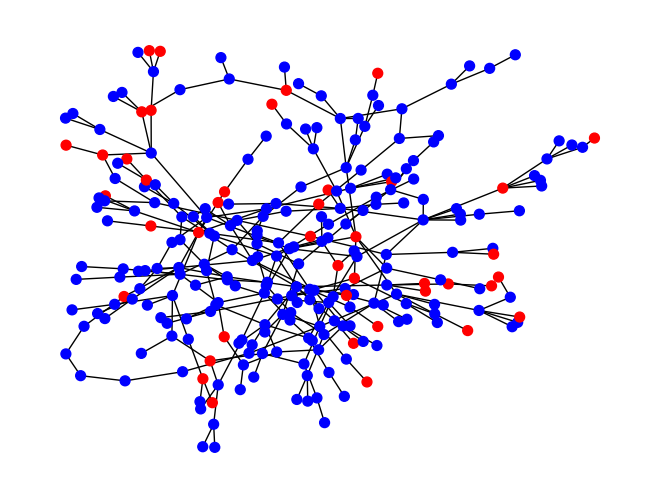

In [ ]:
node_data, degraded_graph, damage_color_map = node_elimination(graph_list[9], verbose=False)

nx.draw(graph_list[9], node_size=50, node_color=damage_color_map)

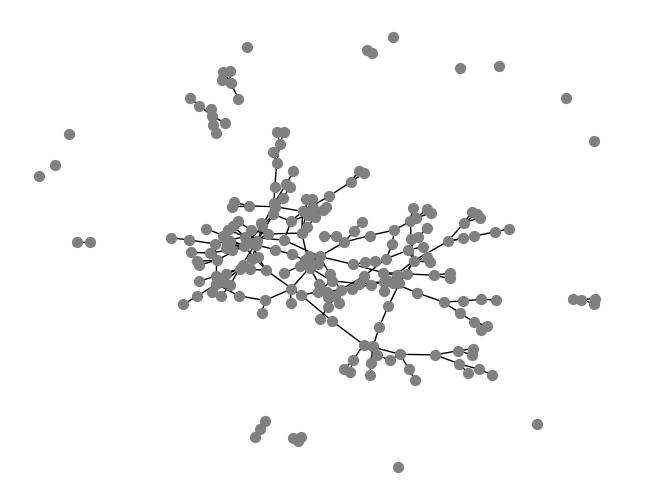

In [ ]:
nx.draw(degraded_graph, node_size=50, node_color='grey')


        Nodes at Start 296
        Connections at Start 4527
        Nodes Removed 88
        Node Elimination Events 88
        Total Number of Nodes at End: 208
        Largest Remaining Segment: 208
        Largest Remaining Segment Connections: 2231
        Network Destroyed (T/F) False
        


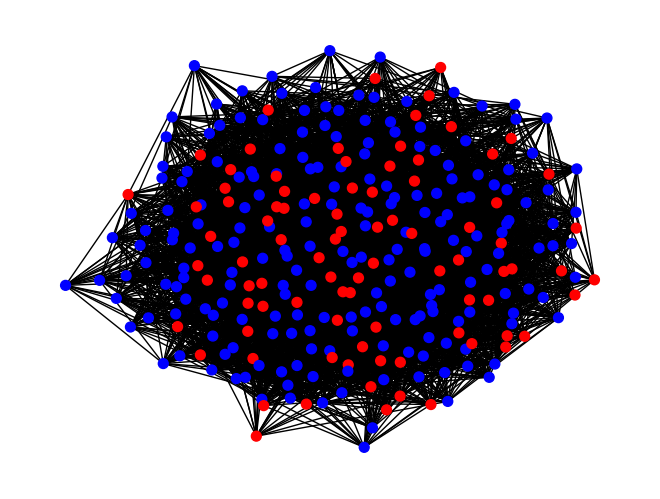

In [ ]:
sublist_ne, sublist_degraded_graph, _ = node_elimination(sublist[5])

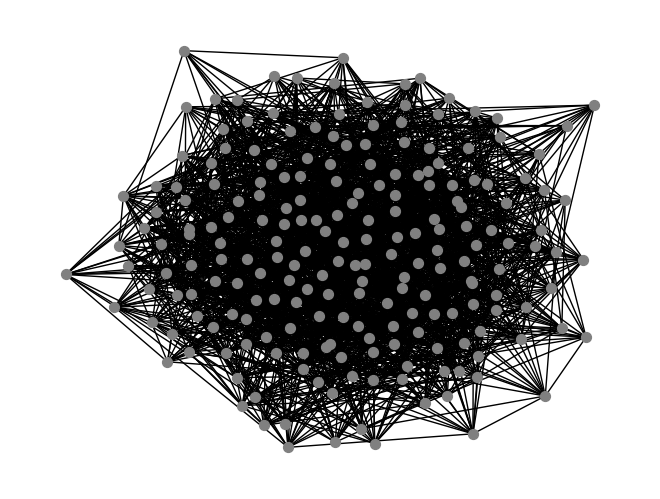

In [ ]:
nx.draw(sublist_degraded_graph, node_size=50, node_color='grey')

In [ ]:
def model_node_eliminations(input_graph, experiments=2000):

    lowest_node_removal = 100
    list_of_nodes_removed = []

    for x in range(0, experiments):
        sublist_ne, sublist_degraded_graph, damage_color_map = node_elimination(input_graph, verbose=False)
        list_of_nodes_removed.append(sublist_ne['nodes_removed'])

        if sublist_ne['nodes_removed'] < lowest_node_removal:
            lowest_node_removal_dict = sublist_ne
            lowest_node_removal_graph = sublist_degraded_graph
            lowest_node_removal = sublist_ne['nodes_removed']
            lowest_node_removal_color_map = damage_color_map
            
    for k in lowest_node_removal_dict.keys():
        print(k, lowest_node_removal_dict[k])
    
    print(f'Average Nodes Removed: {sum(list_of_nodes_removed) / len(list_of_nodes_removed)}')
    
    plt.figure(1)
    nx.draw(input_graph, node_size=50, node_color=lowest_node_removal_color_map)
    
    plt.figure(2)
    nx.draw(lowest_node_removal_graph, node_size=50, node_color='grey')

    plt.show()

nodes_at_start 132
connections_at_start 143
nodes_at_end 126
connections_at_end 120
nodes_removed 6
largest_remaining_segment 88
largest_segment_edge_ct 92
node_elimination_events 6
network_destroyed True
Average Nodes Removed: 19.8125


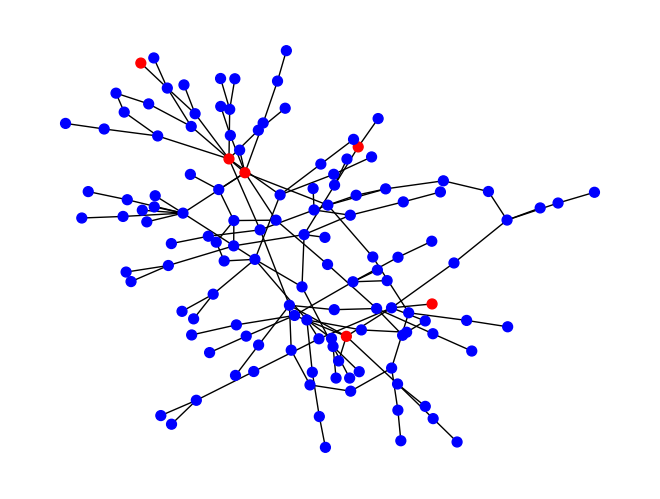

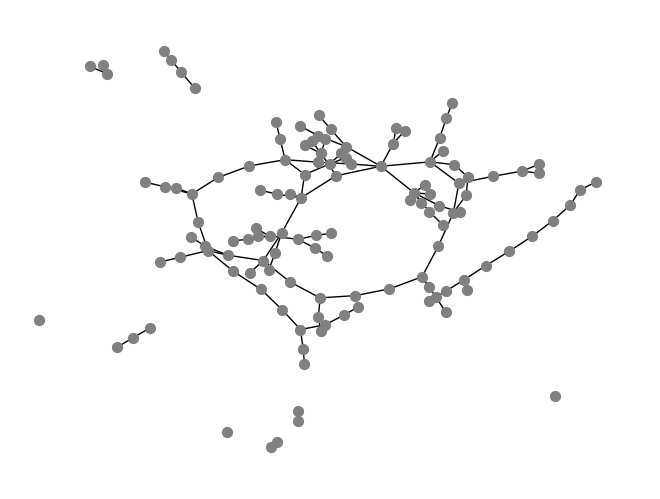

In [ ]:
model_node_eliminations(sublist[0])

nodes_at_start 296
connections_at_start 4527
nodes_at_end 208
connections_at_end 2266
nodes_removed 88
largest_remaining_segment 208
largest_segment_edge_ct 2266
node_elimination_events 88
network_destroyed False
Average Nodes Removed: 88.0


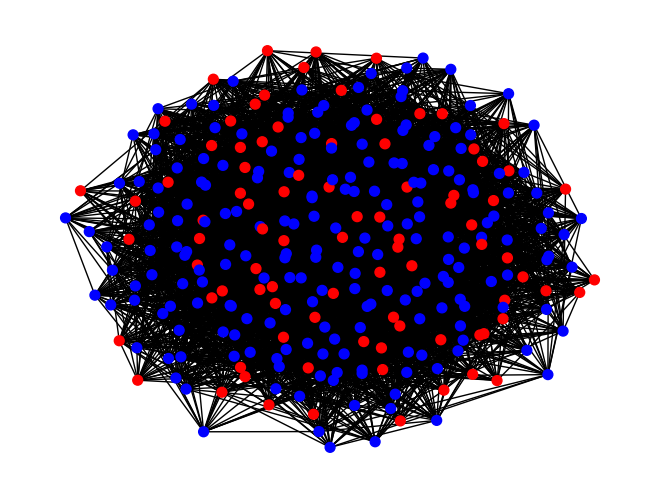

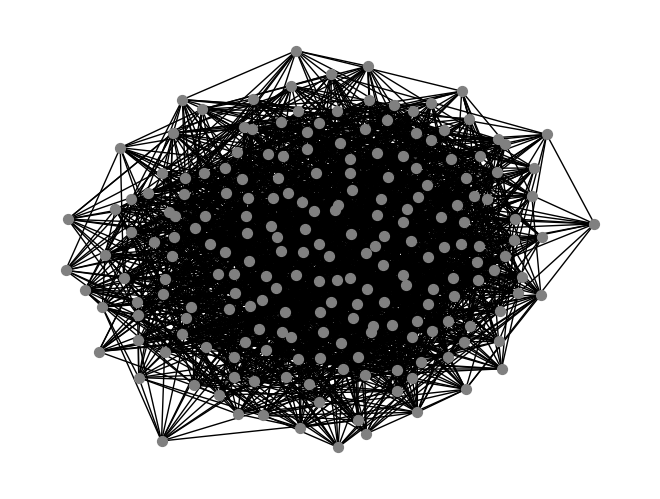

In [ ]:
model_node_eliminations(sublist[5])